In [1]:
import os
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Bidirectional, GlobalMaxPooling1D, Lambda, Concatenate, Dense
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/vijay/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
if len(K.tensorflow_backend._get_available_gpus()) > 0:
  from keras.layers import CuDNNLSTM as LSTM
  from keras.layers import CuDNNGRU as GRU

In [9]:
def get_mnist(limit=None):
  print("Reading in and transforming data...")
  df = pd.read_csv('DATASET/train.csv')
  data = df.values
  np.random.shuffle(data)
  X = data[:, 1:].reshape(-1, 28, 28) / 255.0 # data is from 0..255
  Y = data[:, 0]
  if limit is not None:
    X, Y = X[:limit], Y[:limit]
  return X, Y

In [10]:
# get data
X, Y = get_mnist()

Reading in and transforming data...


In [11]:
# config
D = 28
M = 15

In [12]:
# input is an image of size 28x28
input_ = Input(shape=(D, D))


In [15]:
# up-down
rnn1 = Bidirectional(LSTM(M, return_sequences=True))
x1 = rnn1(input_) # output is N x D x 2M
x1 = GlobalMaxPooling1D()(x1) # output is N x 2M

In [16]:
# left-right
rnn2 = Bidirectional(LSTM(M, return_sequences=True))

In [17]:
# custom layer
permutor = Lambda(lambda t: K.permute_dimensions(t, pattern=(0, 2, 1)))

In [18]:
x2 = permutor(input_)
x2 = rnn2(x2) # output is N x D x 2M
x2 = GlobalMaxPooling1D()(x2) # output is N x 2M

In [19]:
# put them together
concatenator = Concatenate(axis=1)
x = concatenator([x1, x2]) # output is N x 4M

In [20]:
# final dense layer
output = Dense(10, activation='softmax')(x)

model = Model(inputs=input_, outputs=output)

# testing
# o = model.predict(X)
# print("o.shape:", o.shape)

# compile
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# train
print('Training model...')
r = model.fit(X, Y, batch_size=32, epochs=10, validation_split=0.3)

Training model...
Train on 29399 samples, validate on 12601 samples
Epoch 1/10
29399/29399 [==============================] - 28s 937us/step - loss: 0.7949 - acc: 0.8015 - val_loss: 0.2927 - val_acc: 0.9225
Epoch 2/10
29399/29399 [==============================] - 22s 756us/step - loss: 0.2395 - acc: 0.9350 - val_loss: 0.1907 - val_acc: 0.9475
Epoch 3/10
29399/29399 [==============================] - 22s 757us/step - loss: 0.1717 - acc: 0.9514 - val_loss: 0.1522 - val_acc: 0.9552
Epoch 4/10
29399/29399 [==============================] - 22s 749us/step - loss: 0.1382 - acc: 0.9603 - val_loss: 0.1331 - val_acc: 0.9610
Epoch 5/10
29399/29399 [==============================] - 22s 765us/step - loss: 0.1192 - acc: 0.9651 - val_loss: 0.1276 - val_acc: 0.9633
Epoch 6/10
29399/29399 [==============================] - 23s 795us/step - loss: 0.1049 - acc: 0.9691 - val_loss: 0.1112 - val_acc: 0.9664
Epoch 7/10
29399/29399 [==============================] - 23s 773us/step - loss: 0.0962 - acc: 0.9

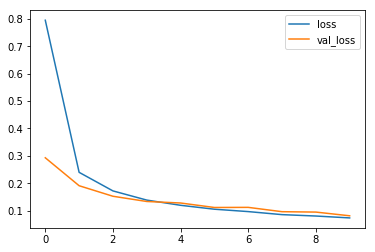

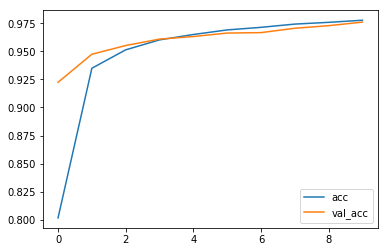

In [21]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()